In [3]:
import os
from dotenv import load_dotenv
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import praw

system_os = os.name
if system_os == "posix":
    os.system("clear")
elif system_os == "nt":
    os.system("cls")

In [4]:
# Cell 1: Authentication and Reddit Data Collection
load_dotenv()

client_id = os.getenv("REDDIT_CLIENT_ID")
client_secret = os.getenv("REDDIT_CLIENT_SECRET")
user_agent = "crypto_sentiment_project"

reddit = praw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=user_agent
)

subreddit = reddit.subreddit("Bitcoin")
posts = subreddit.new(limit=1000)

posts_data = []
for post in posts:
    posts_data.append({
        "Date": pd.to_datetime(post.created_utc, unit='s'),
        "Post_Title": post.title,
        'Text_Post': post.selftext
    })

df_reddit = pd.DataFrame(posts_data)
print("Reddit posts DataFrame (first 5 rows):")
print(df_reddit.head())


Reddit posts DataFrame (first 5 rows):
                 Date                                         Post_Title  \
0 2025-08-05 01:42:05  What am I giving up by using my coldcard with ...   
1 2025-08-05 01:38:59  Experiences with Adam Hudson’s Courses & Algor...   
2 2025-08-05 01:36:19          Difference between buying bitcoin and ETN   
3 2025-08-05 01:15:43  Assets with CAGR >20% per year over past 50 years   
4 2025-08-05 01:12:28                                 Fiat going to zero   

                                           Text_Post  
0  I would use my coldcard mk4 with sparrow but I...  
1  Has anyone taken Adam Hudson’s courses or trie...  
2  Hello, I'm quite new to the whole investing an...  
3  I asked ChatGPT to calculate assets with great...  
4                                                  M  


In [7]:
# Cell 2: Sentiment Analysis and Data Merging
df_reddit["Full_Text"] = df_reddit["Post_Title"] + ' ' + df_reddit["Text_Post"]

analyzer = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    if not isinstance(text, str) or text.strip() == "":
        return 0
    vs = analyzer.polarity_scores(text)
    return vs["compound"]

df_reddit["sentiment_score"] = df_reddit["Full_Text"].apply(get_sentiment_score)
df_reddit["Date"] = pd.to_datetime(df_reddit["Date"]).dt.date

day_sentiment = df_reddit.groupby("Date")["sentiment_score"].mean().reset_index()
print("\nAverage sentiment per day:")
print(day_sentiment)

price_data = yf.download("BTC-USD", period="3mo", interval="1d")
price_data.columns = price_data.columns.get_level_values(0)
price_data.index = price_data.index.date 

day_sentiment.rename(columns={"Date": "Date"}, inplace=True)
day_sentiment.set_index("Date", inplace=True)

final_data = pd.merge(price_data, day_sentiment, left_index=True, right_index=True)
print("\nMerged DataFrame (first 5 rows):")
print(final_data.head())

real_correlation = final_data['sentiment_score'].corr(final_data['Close'])
print(f"\nReddit Sentiment and Price Correlation Coefficient: {real_correlation}")


Average sentiment per day:
          Date  sentiment_score
0   2025-07-23         0.225839
1   2025-07-24         0.321323
2   2025-07-25         0.318243
3   2025-07-26         0.342403
4   2025-07-27         0.286916
5   2025-07-28         0.356536
6   2025-07-29         0.381832
7   2025-07-30         0.429881
8   2025-07-31         0.266364
9   2025-08-01         0.166232
10  2025-08-02         0.336603
11  2025-08-03         0.469567
12  2025-08-04         0.318174
13  2025-08-05         0.057057


/tmp/ipykernel_13957/3119426091.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_data = yf.download("BTC-USD", period="3mo", interval="1d")
[*********************100%***********************]  1 of 1 completed


Merged DataFrame (first 5 rows):
                    Close           High            Low           Open  \
2025-07-23  118754.960938  120113.351562  117391.390625  119997.445312   
2025-07-24  118368.000000  119535.453125  117247.968750  118770.984375   
2025-07-25  117635.882812  118486.976562  114759.820312  118368.000000   
2025-07-26  117947.367188  118335.687500  117181.226562  117644.843750   
2025-07-27  119448.492188  119815.593750  117859.687500  117944.726562   

                  Volume  sentiment_score  
2025-07-23   66608604537         0.225839  
2025-07-24   72627318560         0.321323  
2025-07-25  104857024569         0.318243  
2025-07-26   48508954046         0.342403  
2025-07-27   54683390892         0.286916  

Reddit Sentiment and Price Correlation Coefficient: 0.415604004814807


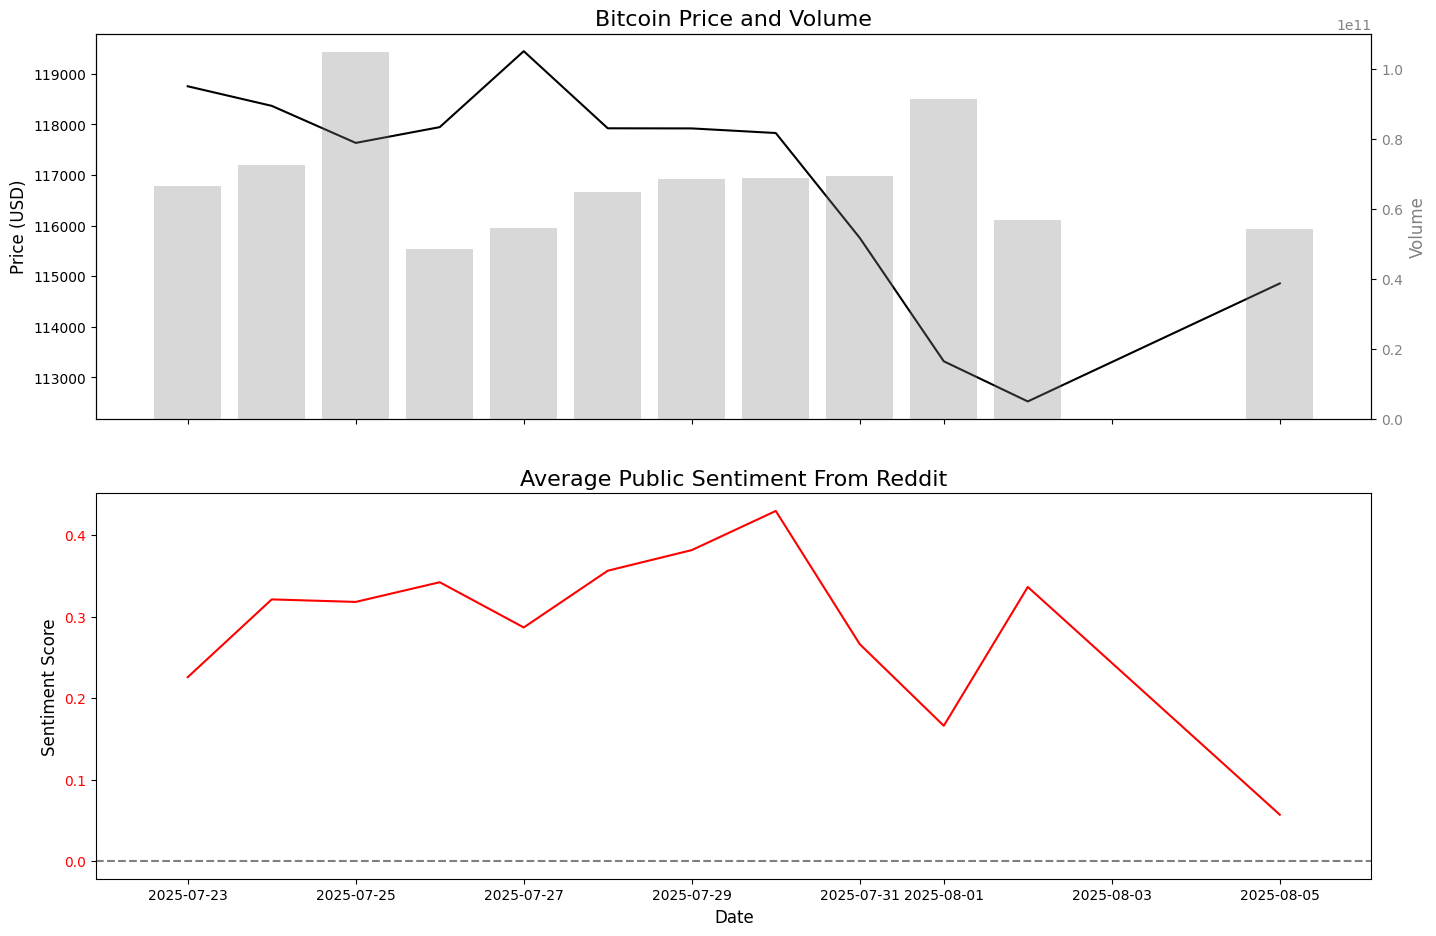

In [8]:
# Cell 3: Data Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

ax1.set_title('Bitcoin Price and Volume', fontsize=16)
ax1.set_ylabel('Price (USD)', color='black', fontsize=12)
ax1.plot(final_data.index, final_data['Close'], color='black', label='Closing Price')
ax1.tick_params(axis='y', labelcolor='black')

ax1_twin = ax1.twinx()
ax1_twin.set_ylabel('Volume', color='grey', fontsize=12)
ax1_twin.bar(final_data.index, final_data['Volume'], color='grey', alpha=0.3)
ax1_twin.tick_params(axis='y', labelcolor='grey')

ax2.set_title('Average Public Sentiment From Reddit', fontsize=16)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Sentiment Score', color='black', fontsize=12)
ax2.plot(final_data.index, final_data['sentiment_score'], color='red')
ax2.tick_params(axis='y', labelcolor='red')

ax2.axhline(y=0, color='gray', linestyle='--', linewidth=1.5)

fig.tight_layout(pad=3.0)

plt.show()